#### Adaptive Implementation design

1. Solving classical system
2. Finding values of optimal $C^s$

### Solve a classical system of differential equations
Here we just program a function that solves the classic ODE system:

$$
\begin{align*}
    &\frac{dS}{dt}= -C(\cdot)\beta SI/N\\
    &\frac{dI}{dt}= C(\cdot)\beta SI/N -\nu I \\
    &\frac{dZ}{dt}=\nu I.
\end{align*}
$$

Depending on the value of the constant $C(\cdot) \in \mathbb{R}_{>0}$.

In [ ]:
from scipy.integrate import odeint
from scipy.optimize import fmin
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d ### Might be useful

### Utils

def plot_ode_solution(S,I,Z,model):
    plt.plot(t,S,label="Susceptible")
    plt.plot(t,I,label="Infected")
    plt.plot(t,Z,label="Recovered (Immune)")
    plt.title(f"Plot of S-I-Z functions ({model})")
    plt.xlabel("Time (t)")
    plt.ylabel("Number of individuals")
    plt.legend(loc="upper right")
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()

##### Solve classical SIR model with constant C(.) and parameters

In [ ]:
def odes_simple(x, t, c, beta, nu, N):

    # assign each function to a vector element
    S = x[0]
    I = x[1]
    Z = x[2]

    # classical system depending on c, beta, nu and N
    dSdt = -(beta/N)*5*S*I 
    dIdt = (beta/N)*5*S*I - nu*I 
    dZdt = nu*I 

    return [dSdt, dIdt, dZdt]

#### Example

We solve a classical SIR model with non adaptive contact rate.

In [ ]:
def solve_classical_SIR(x0,c,beta,nu,t_max,h):
    
    """
    Solve the classical system with initial conditions
    x_0 = [S_0,I_0,Z_0]
    c,beta,nu parameters of the classical ODE's system.
    Solve for t in [0,t_max]
    Create linspace with points seperated by an uniform distance of h
    """
    S0,I0,Z0= x0[0],x0[1],x0[2]
    N=sum(x0)
    
    t = np.linspace(0,t_max,int(t_max/h))
    x = odeint(odes_simple, x0, t, args=(c,beta,nu,N))

    S = x[:,0]
    I = x[:,1]
    Z = x[:,2]
    
    return S,I,Z

In [ ]:
### Initial Conditions
S0 = 30000
I0 = 1000
Z0 = 200
x0 = [S0, I0, Z0]

### Model parameters
c=5
beta=0.0925
nu=0.1823

### Solution x-axis steps
t_max=60
h=60/1000

### Solve
S,I,Z = solve_classical_SIR(x0,c,beta,nu,t_max,h)

### Plot
plot_ode_solution(S,I,Z,"classical")

#### Adaptive approach

The constant $C(\cdot)$ changes through time using a planning window.

The formula for $C(\cdot)$ is given by

$$
C(\cdot)(t) = C^{si}(t) = \frac{N \cdot C^s(t) \cdot C^i(t)}{S(t)\cdot C^s(t) + I(t)\cdot C^i(t) + Z(t) \cdot C^z(t)},
$$

where

- $C^h(t)$ is the optimal number of average contacts made by individuals of type $h \in Y=\{s,i,z\}$ at time $t$.
- $S(t),I(t),Z(t)$ are the number of susceptible, infected and recovered individuals at time $t$.
- $N$ is the entirety of the population.

Thus, in order to find $C(\cdot)(t)$ we need to find the values of the functions of optimal average contacts $C^h(t)$ for $h \in Y$.

For individuals of types $i$ and $z$ the optimal number of average contacts are given by $C^h(t)= 0.5b^h$ where $b^h$ is a given constant. For indiviuals of type $s$ the adaptive algorithm enters the play.

So for each time there is an optimal $C_t^{s*}$ that has to be introduced into the model to solve it. We program the next function that solves the classical SIR model using a $C_t^{s*}$ imput (as a vector)

In [444]:
### Solves the ODE system in an interval 
### We need to implement the computation of C_t^{s*}

def get_Cs_opt(S,I,Z,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t):
    
    """
    Select the optimal C_t^s in the interval [0, 0.5b^s] for which we attain the maximum of the 
    value function. For now I'm using the direct implementation from equation (2.2) in the notes.
    We might need to review this and instead use the backwards induction technique (not clear how!).
    
    Attributes:
    - values of S_t,I_t,Z_t at time t.
    - adaptive utility parameters b^z,b^i,b^s,gamma.
    - time window planning info: tau, delta.
    - SIR model parameters: beta, nu.
    - time: t
    """
    
    phi_t = S*0.5*bs + I*0.5*bi + Z*0.5*bz  ### Questions
    
    Pz = 1 - math.exp(-1*nu)  ### Probability of recovery.
    xi = ( (1 - delta**(tau+1) )/(1 - delta) ) - ( (1 - ( delta*(1-Pz) )**(tau+1)  )/( 1 - delta*(1-Pz) ) ) ### Xi function in notes
    vti = ((0.25* (bz)**2 )**gamma - az)*xi ### Value of V_{t+1}(i) for t inside interval.
     
    ### Probability that an s-type individual becomes infected at time t.
    ### Depends on selection of C_s^t
    
    def P_it(C_st):
        P_it = 1 - math.exp(-1*(0.5*beta*bi*I*C_st)/phi_t)
        return P_it
    
    def value_func_arg(C_st):
        expr0 = 0.5*beta*bi*I*math.exp(-1*(0.5*beta*bi*I*C_st)/phi_t)
        expr1 = (gamma*(bs*C_st - C_st**2)**(gamma-1) + bs -2*C_st) / expr0
        expr2 = (1 - P_it(C_st))*expr1 + vti
        return (bs*C_st - C_st**2)**gamma - as1 - delta*expr2
    
    C_st_array = np.linspace(0,0.5*bs,1000)
    Cs_opt = np.argmax([value_func_arg(C_st) for C_st in C_st_array])

    print(f" t: {t}. C_t^s* selected: {C_st_array[Cs_opt]}. ")  ### TODO: Check this, it's always giving me the same selected value.
    
    return Cs_opt

In [445]:
def odes_adaptive(x, t, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu):

    # assign each function to a vector element
    S = x[0]
    I = x[1]
    Z = x[2]
    
    Cs_opt = get_Cs_opt(S,I,Z,bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu,t)
    
    # classical system depending on c, beta, nu and N
    dSdt = -(beta/N)*(Cs_opt*0.5*bi*N/(S*Cs_opt+I*0.5*bi+Z*0.5*bz) )*S*I 
    dIdt = (beta/N)*(Cs_opt*0.5*bi*N/(S*Cs_opt+I*0.5*bi+Z*0.5*bz) )*S*I - nu*I 
    dZdt = nu*I 

    return [dSdt, dIdt, dZdt]

In [446]:
def solve_adaptive_SIR(x0, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu, t_max,h):
    
    """
    Solve the classical system with initial conditions
    x_0 = [S_0,I_0,Z_0]
    c,beta,nu parameters of the classical ODE's system.
    Solve for t in [0,t_max]
    Create linspace with points seperated by an uniform distance of h
    """
    
    S0,I0,Z0= x0[0],x0[1],x0[2]
    N=sum(x0)
    
    t = np.linspace(0,t_max,int(t_max/h))
    x = odeint(odes_adaptive, x0, t, args=(bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu))

    S = x[:,0]
    I = x[:,1]
    Z = x[:,2]
    
    return S,I,Z

Experiments

C:\Users\jimmy\AppData\Local\Temp/ipykernel_25120/1742055790.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  expr1 = (gamma*(bs*C_st - C_st**2)**(gamma-1) + bs -2*C_st) / expr0


 t: 0.0. C_t^s* selected: 5.0. 
 t: 7.320706743083142e-06. C_t^s* selected: 5.0. 
 t: 7.320706743083142e-06. C_t^s* selected: 5.0. 
 t: 1.4641413486166284e-05. C_t^s* selected: 5.0. 
 t: 1.4641413486166284e-05. C_t^s* selected: 5.0. 
 t: 0.016495765132603344. C_t^s* selected: 5.0. 
 t: 0.016495765132603344. C_t^s* selected: 5.0. 
 t: 0.03297688885172052. C_t^s* selected: 5.0. 
 t: 0.03297688885172052. C_t^s* selected: 5.0. 
 t: 0.049458012570837706. C_t^s* selected: 5.0. 
 t: 0.049458012570837706. C_t^s* selected: 5.0. 
 t: 0.13465552500819566. C_t^s* selected: 5.0. 
 t: 0.13465552500819566. C_t^s* selected: 5.0. 
 t: 0.10658575694161054. C_t^s* selected: 5.0. 
 t: 0.10658575694161054. C_t^s* selected: 5.0. 
 t: 0.060883561444992275. C_t^s* selected: 5.0. 
 t: 0.060883561444992275. C_t^s* selected: 5.0. 
 t: 0.07230911031914684. C_t^s* selected: 5.0. 
 t: 0.07230911031914684. C_t^s* selected: 5.0. 
 t: 0.08373465919330142. C_t^s* selected: 5.0. 
 t: 0.08373465919330142. C_t^s* selected

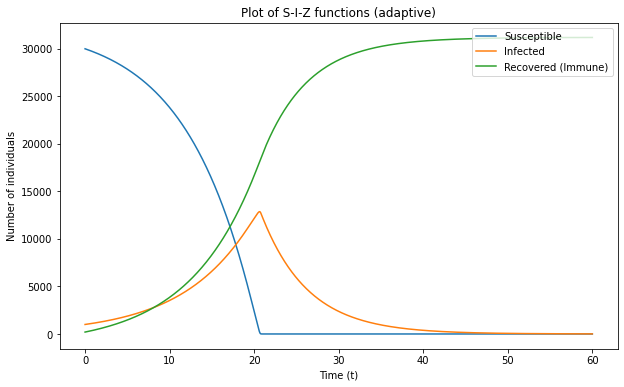

In [447]:
### Initial Conditions
S0 = 30000
I0 = 1000
Z0 = 200
x0 = [S0, I0, Z0]

### Model parameters
beta=0.0925
nu=0.1823

### Adaptive parameters
bi=6.67
bz=10
bs=bz

ai=1.826
az=0 ### By default
as1=0 ### By default
gamma=0.25
tau=19
delta=0.99986

### Solution x-axis steps
t_max=60
h=60/1000

### Solve
S,I,Z = solve_adaptive_SIR(x0, bi,bz,bs,ai,az,as1,gamma,tau,delta,beta,nu, t_max,h)

### Plot
plot_ode_solution(S,I,Z,"adaptive")